In [17]:
import pandas as pd

train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
print(train_df.shape, test_df.shape)

(891, 12) (418, 11)


In [18]:
train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## 01. EDA

### Q. 성별에 따른 생존율은?

In [19]:
import matplotlib.pyplot as plt

sex_pivot = train_df.pivot_table(index="Sex",values="Survived")
sex_pivot

,Survived
Sex,
female,0.742038
male,0.188908


### Q. 좌석 Class에 따른 생존율은?

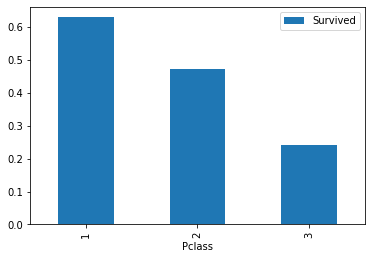

In [20]:
pclass_pivot = train_df.pivot_table(index="Pclass",values="Survived")
pclass_pivot.plot.bar()
plt.show()

### Age는 어떻게 분포하고 있을까?

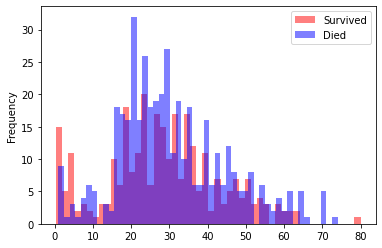

In [21]:
import matplotlib.pyplot as plt

survived = train_df[train_df["Survived"] == 1]
died = train_df[train_df["Survived"] == 0]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

#### 나이대별로 생존율이 다를 수도 있겠다.. 유아의 생존율은 상당히 높음.

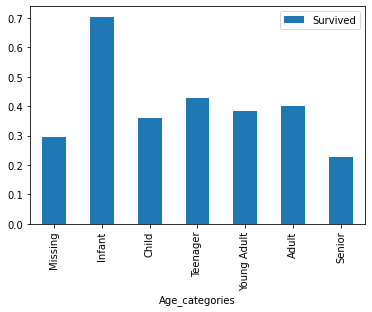

In [22]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points = [-1, 0, 5, 12, 18, 35, 60, 100] # length = 8
label_names = ["Missing", 'Infant', "Child", 'Teenager', "Young Adult", 'Adult', 'Senior'] # length = 7

train_df = process_age(train_df,cut_points,label_names)
test_df = process_age(test_df,cut_points,label_names)

age_cat_pivot = train_df.pivot_table(index="Age_categories",values="Survived")
age_cat_pivot.plot.bar()
plt.show()

## 2. Preparing Our Data for Machine Learning

### One-hot encoding

In [23]:
column_name = "Pclass"
df = train_df
dummies = pd.get_dummies(df[column_name],prefix=column_name)
dummies.head(3)

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1


In [24]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train_df = create_dummies(train_df,"Pclass")
test_df = create_dummies(test_df,"Pclass")
train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_categories,Pclass_1,Pclass_2,Pclass_3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Young Adult,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adult,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Young Adult,0,0,1


In [25]:
train_df = create_dummies(train_df,"Sex")
test_df = create_dummies(test_df,"Sex")
train_df = create_dummies(train_df,"Age_categories")
test_df = create_dummies(test_df,"Age_categories")
train_df.shape

(891, 25)

## 3. Creating Our First Machine Learning Model


In [29]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

In [30]:
holdout = test_df

from sklearn.model_selection import train_test_split

all_X = train_df[columns]
all_y = train_df['Survived']
train_X, test_X, train_y, test_y = train_test_split(all_X, all_y, test_size=0.2,random_state=0)
train_X.shape

(712, 12)

In [31]:
lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)

In [32]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_y, predictions)
accuracy

0.8100558659217877

In [33]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(test_y, predictions)
pd.DataFrame(conf_matrix, columns=['Survived', 'Died'], index=[['Survived', 'Died']])

,Survived,Died
Survived,96,14
Died,20,49


#### Cross Validation

In [34]:
from sklearn.model_selection import cross_val_score
import numpy as np

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
np.mean(scores)

0.8024719101123596

In [35]:
lr = LogisticRegression()
lr.fit(all_X, all_y)
# End of Learning
holdout_predictions = lr.predict(holdout[columns])
holdout_predictions

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

In [37]:
holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv('data/titanic_submission.csv', index=False)

In [38]:
!kaggle competitions submit -f data/titanic_submission.csv -m "Using JupyterLab" titanic

100%|████████████████████████████████████████| 2.77k/2.77k [00:04<00:00, 621B/s]
Successfully submitted to Titanic: Machine Learning from Disaster

In [40]:
!kaggle competitions submissions titanic

fileName                   date                 description                                                                                     status    publicScore  privateScore  
-------------------------  -------------------  ----------------------------------------------------------------------------------------------  --------  -----------  ------------  
titanic_submission.csv     2020-07-05 08:36:05  Using JupyterLab                                                                                complete  0.76315      None          
titanic_submission.csv     2020-07-05 08:35:35  Using JupyterLab                                                                                complete  0.76315      None          
titanic_submission.csv     2020-06-09 15:41:24  Solution From "Kaggle Titanic Tutorial"
https://www.kaggle.com/sashr07/kaggle-titanic-tutorial  complete  0.76315      None          
(Challenge001/RD) Titanic  2018-12-12 08:53:33  From "(Challenge001/RD) Titanic" Script   